Enter start year (e.g., 2015): 2015
Enter end year (e.g., 2024): 2025

Backtest Period: 2015 to 2025
Actual Date Range: 2015-01-01 to 2025-08-01
Total Months: 128
            Portfolio   Final Value   CAGR% Max Drawdown%
0       Lump Sum Cash   ₹27,813,802  10.15%       -29.34%
1  Lump Sum + Overlay  ₹140,999,929  28.41%       -18.40%
2           Plain SIP   ₹25,357,992  12.42%       -26.11%
3       SIP + Overlay   ₹80,496,697  32.48%       -16.47%


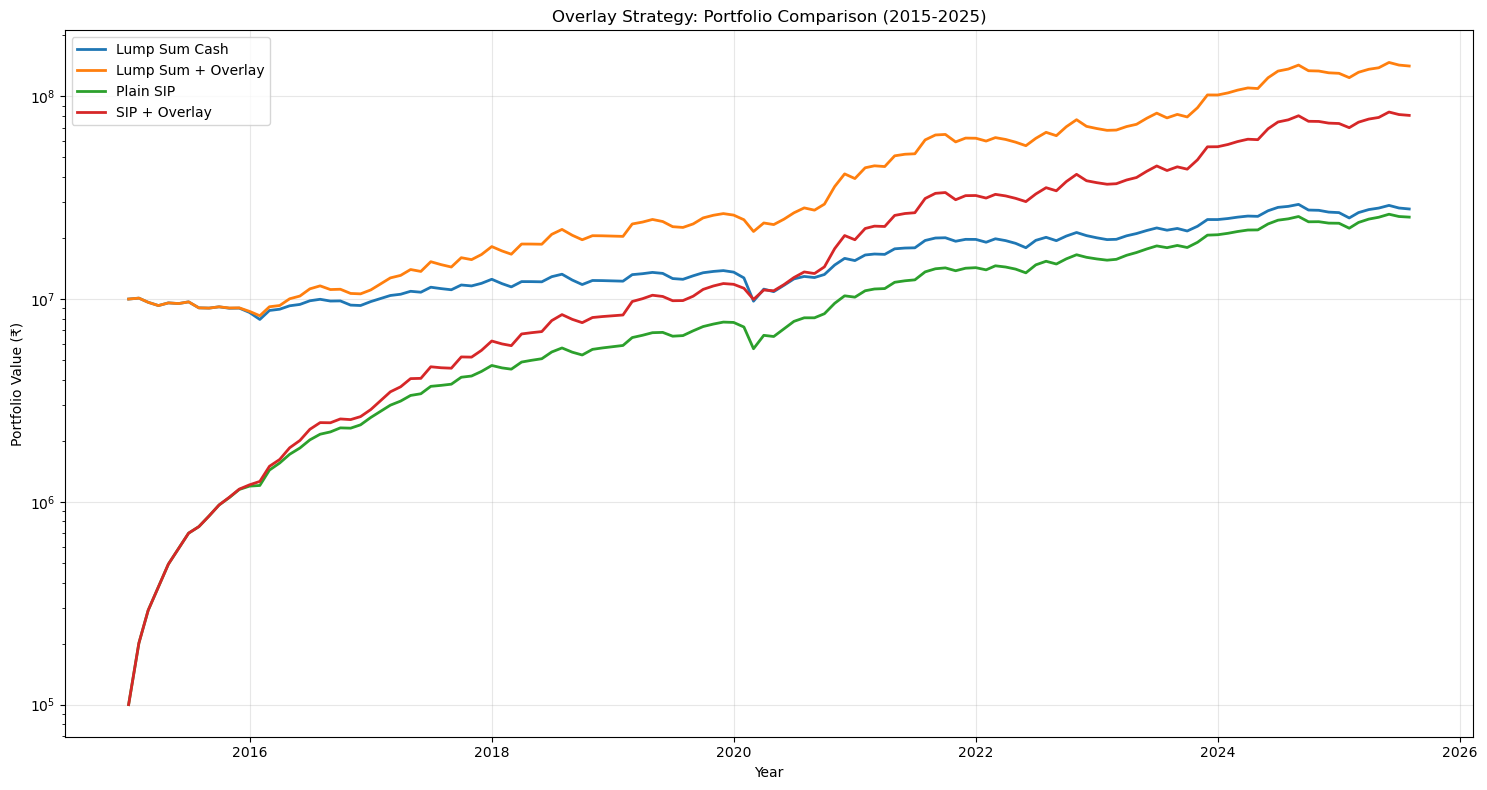


ADDITIONAL ANALYSIS
Total SIP Investment: ₹12,800,000
Plain SIP Multiple: 1.98x
SIP + Overlay Multiple: 6.29x

Overlay Benefit:
Lump Sum: 406.94%
SIP: 217.44%


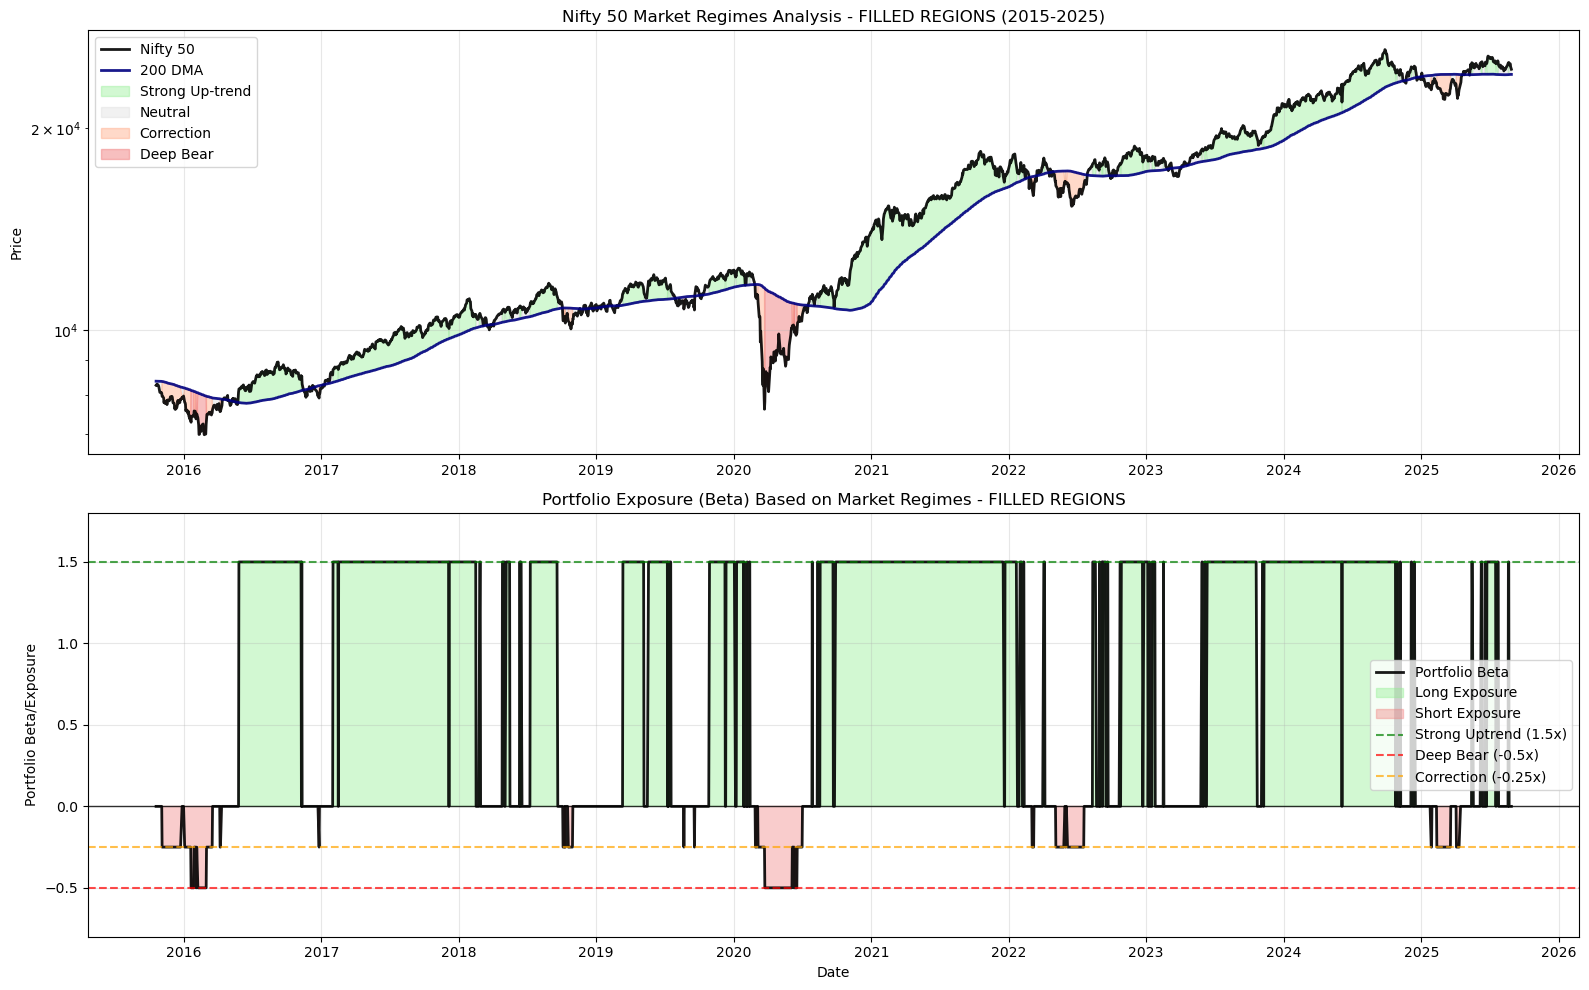


REGIME STATISTICS
Regime Distribution:
Strong up-trend: 1386 days (56.8%) - Beta: 1.5
Neutral: 790 days (32.4%) - Beta: 0
Correction: 189 days (7.7%) - Beta: -0.25
Deep bear: 77 days (3.2%) - Beta: -0.5

Total trading days analyzed: 2641


In [2]:
# %% Full Overlay Backtest with SIP and Lump Sum

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy_financial as npf

# ---------------------------
# User Input for Date Range
# ---------------------------
start_year = int(input("Enter start year (e.g., 2015): "))
end_year = int(input("Enter end year (e.g., 2024): "))

# ---------------------------
# Load CSV
# ---------------------------
df = pd.read_csv('/Users/tejamuttana/Downloads/Nifty 50 Historical Data (3).csv', parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# Filter data based on user input
df = df[(df["Date"].dt.year >= start_year) & (df["Date"].dt.year <= end_year)].reset_index(drop=True)

# Clean numeric column (assume 'Price' column)
df["Price"] = df["Price"].astype(str).str.replace(",", "")
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")

# Compute 200DMA and slope (~3 months)
df["200DMA"] = df["Price"].rolling(200).mean()
df["200DMA_slope"] = df["200DMA"].diff(63)

# Month-end
df["Month"] = df["Date"].dt.to_period("M")
monthly_df = df.groupby("Month").last().reset_index()

# ---------------------------
# Parameters
# ---------------------------
lot_size = 50
fut_basis = 0.002
tax_rate = 0.30
lumpsum_eq = 1_00_00_000
sip_amount = 1_00_000

# ---------------------------
# Overlay decision function
# ---------------------------
def overlay_decision(spot, dma200, slope):
    if np.isnan(dma200):
        return 0.0, "No DMA"
    gap = (spot - dma200)/dma200
    if gap >= 0.04:
        return 1.5, "Strong up-trend"  # 150% exposure (100% equity + 50% futures)
    elif gap <= -0.08 and slope < 0:
        return -0.50, "Deep bear"      # -50% SHORT exposure
    elif gap <= -0.04:
        return -0.25, "Correction"
    else:
        return 0.0, "Neutral"

# ---------------------------
# Initialize portfolios
# ---------------------------
lumpsum_cash = lumpsum_eq
lumpsum_overlay = lumpsum_eq
sip_overlay = 0.0
sip_cash = 0.0
sip_plain = 0.0  # Added plain SIP
sip_cum = 0.0

# Track curves
dates = []
lumpsum_cash_curve = []
lumpsum_overlay_curve = []
sip_cash_curve = []
sip_overlay_curve = []
sip_plain_curve = []  # Added plain SIP curve

# Track SIP cashflows for IRR
sip_overlay_cashflows = []
sip_plain_cashflows = []  # Added plain SIP cashflows

# Track regime data for all data plot
all_dates = []
all_prices = []
all_dma200 = []
all_regimes = []

prev_spot = None

# ---------------------------
# Backtest loop
# ---------------------------
for idx, row in monthly_df.iterrows():
    spot = row["Price"]
    dma200 = row["200DMA"]
    slope = row["200DMA_slope"]
    fut_close = spot * (1 + fut_basis)

    beta, regime = overlay_decision(spot, dma200, slope)
    contract_notional = fut_close * lot_size

    # Monthly return
    month_return = 0.0 if prev_spot is None else (spot - prev_spot)/prev_spot

    # --- Lump sum cash
    lumpsum_cash *= (1 + month_return)
    lumpsum_cash_curve.append(lumpsum_cash)

    # --- Lump sum overlay
    lots_ls = int(round(beta * lumpsum_overlay / contract_notional))
    overlay_pnl_ls = 0.0 if prev_spot is None else lots_ls * lot_size * (spot - prev_spot) * (1 - tax_rate)
    lumpsum_overlay = lumpsum_overlay*(1 + month_return) + overlay_pnl_ls
    lumpsum_overlay_curve.append(lumpsum_overlay)

    # --- SIP cash
    sip_cum += sip_amount
    sip_cash = sip_cash*(1 + month_return) + sip_amount
    sip_cash_curve.append(sip_cash)

    # --- SIP overlay
    lots_sip = int(round(beta * (sip_overlay + sip_amount) / contract_notional))
    overlay_pnl_sip = 0.0 if prev_spot is None else lots_sip * lot_size * (spot - prev_spot) * (1 - tax_rate)
    sip_overlay = sip_overlay*(1 + month_return) + sip_amount + overlay_pnl_sip
    sip_overlay_curve.append(sip_overlay)

    # --- Plain SIP (just equity investment)
    sip_plain = sip_plain*(1 + month_return) + sip_amount
    sip_plain_curve.append(sip_plain)

    # --- SIP cashflows for IRR
    sip_overlay_cashflows.append(-sip_amount)
    sip_plain_cashflows.append(-sip_amount)
    
    if idx == len(monthly_df)-1:
        sip_overlay_cashflows[-1] += sip_overlay  # final positive cashflow
        sip_plain_cashflows[-1] += sip_plain  # final positive cashflow for plain SIP

    dates.append(row["Month"].to_timestamp())
    prev_spot = spot

# ---------------------------
# Prepare data for all-data regime plot
# ---------------------------
for idx, row in df.iterrows():
    spot = row["Price"]
    dma200 = row["200DMA"]
    slope = row["200DMA_slope"]
    
    beta, regime = overlay_decision(spot, dma200, slope)
    
    all_dates.append(row["Date"])
    all_prices.append(spot)
    all_dma200.append(dma200)
    all_regimes.append(regime)

# ---------------------------
# Metrics - IMPROVED CAGR CALCULATIONS
# ---------------------------
def cagr_accurate(values, start_date, end_date):
    """Calculate CAGR using actual date difference"""
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    n_years = (end_date - start_date).days / 365.25
    return (values[-1]/values[0])**(1/n_years) - 1

def max_drawdown(values):
    values = np.array(values)
    peak = np.maximum.accumulate(values)
    drawdown = (values - peak)/peak
    return drawdown.min()

# Get actual start and end dates
actual_start_date = dates[0]
actual_end_date = dates[-1]

# Lump sum metrics - using actual date range
cagr_lumpsum_cash = cagr_accurate(lumpsum_cash_curve, actual_start_date, actual_end_date)
cagr_lumpsum_overlay = cagr_accurate(lumpsum_overlay_curve, actual_start_date, actual_end_date)
dd_lumpsum_cash = max_drawdown(lumpsum_cash_curve)
dd_lumpsum_overlay = max_drawdown(lumpsum_overlay_curve)

# SIP CAGR using monthly IRR - with error handling
try:
    sip_overlay_monthly_irr = npf.irr(sip_overlay_cashflows)
    if np.isnan(sip_overlay_monthly_irr) or sip_overlay_monthly_irr is None:
        # Fallback: calculate using portfolio value method
        cagr_sip_overlay = cagr_accurate(sip_overlay_curve, actual_start_date, actual_end_date)
        print("Warning: Using fallback CAGR calculation for SIP Overlay")
    else:
        cagr_sip_overlay = (1 + sip_overlay_monthly_irr)**12 - 1
except:
    cagr_sip_overlay = cagr_accurate(sip_overlay_curve, actual_start_date, actual_end_date)
    print("Warning: IRR calculation failed for SIP Overlay, using fallback")

dd_sip_overlay = max_drawdown(sip_overlay_curve)

# Plain SIP CAGR using monthly IRR - with error handling  
try:
    sip_plain_monthly_irr = npf.irr(sip_plain_cashflows)
    if np.isnan(sip_plain_monthly_irr) or sip_plain_monthly_irr is None:
        # Fallback: calculate using portfolio value method
        cagr_sip_plain = cagr_accurate(sip_plain_curve, actual_start_date, actual_end_date)
        print("Warning: Using fallback CAGR calculation for Plain SIP")
    else:
        cagr_sip_plain = (1 + sip_plain_monthly_irr)**12 - 1
except:
    cagr_sip_plain = cagr_accurate(sip_plain_curve, actual_start_date, actual_end_date)
    print("Warning: IRR calculation failed for Plain SIP, using fallback")

dd_sip_plain = max_drawdown(sip_plain_curve)

# ---------------------------
# Display metrics with validation
# ---------------------------
print(f"\nBacktest Period: {start_year} to {end_year}")
print(f"Actual Date Range: {actual_start_date.strftime('%Y-%m-%d')} to {actual_end_date.strftime('%Y-%m-%d')}")
print(f"Total Months: {len(dates)}")
print("="*60)

metrics = {
    "Portfolio": ["Lump Sum Cash", "Lump Sum + Overlay", "Plain SIP", "SIP + Overlay"],
    "Final Value": [f"₹{lumpsum_cash_curve[-1]:,.0f}", f"₹{lumpsum_overlay_curve[-1]:,.0f}", 
                   f"₹{sip_plain_curve[-1]:,.0f}", f"₹{sip_overlay_curve[-1]:,.0f}"],
    "CAGR%": [f"{cagr_lumpsum_cash*100:.2f}%", f"{cagr_lumpsum_overlay*100:.2f}%", 
              f"{cagr_sip_plain*100:.2f}%", f"{cagr_sip_overlay*100:.2f}%"],
    "Max Drawdown%": [f"{dd_lumpsum_cash*100:.2f}%", f"{dd_lumpsum_overlay*100:.2f}%", 
                     f"{dd_sip_plain*100:.2f}%", f"{dd_sip_overlay*100:.2f}%"]
}

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

# ---------------------------
# Plot portfolios
# ---------------------------
plt.figure(figsize=(15,8))
plt.plot(dates, lumpsum_cash_curve, label="Lump Sum Cash", linewidth=2)
plt.plot(dates, lumpsum_overlay_curve, label="Lump Sum + Overlay", linewidth=2)
plt.plot(dates, sip_plain_curve, label="Plain SIP", linewidth=2)
plt.plot(dates, sip_overlay_curve, label="SIP + Overlay", linewidth=2)
plt.title(f"Overlay Strategy: Portfolio Comparison ({start_year}-{end_year})")
plt.ylabel("Portfolio Value (₹)")
plt.xlabel("Year")
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale for better visualization
plt.tight_layout()
plt.show()

# ---------------------------
# Additional Analysis
# ---------------------------
print("\n" + "="*60)
print("ADDITIONAL ANALYSIS")
print("="*60)

# Calculate total invested amount for SIP strategies
total_sip_invested = sip_amount * len(monthly_df)
print(f"Total SIP Investment: ₹{total_sip_invested:,.0f}")
print(f"Plain SIP Multiple: {sip_plain_curve[-1]/total_sip_invested:.2f}x")
print(f"SIP + Overlay Multiple: {sip_overlay_curve[-1]/total_sip_invested:.2f}x")

# Overlay benefit
overlay_benefit_lumpsum = (lumpsum_overlay_curve[-1] - lumpsum_cash_curve[-1]) / lumpsum_cash_curve[-1] * 100
overlay_benefit_sip = (sip_overlay_curve[-1] - sip_plain_curve[-1]) / sip_plain_curve[-1] * 100

print(f"\nOverlay Benefit:")
print(f"Lump Sum: {overlay_benefit_lumpsum:.2f}%")
print(f"SIP: {overlay_benefit_sip:.2f}%")

# ---------------------------
# Plot regime analysis on full data - WITH FILLED REGIONS
# ---------------------------
plt.figure(figsize=(16,10))

# Create color map for regimes
regime_colors = {
    "Strong up-trend": "green",
    "Neutral": "gray", 
    "Correction": "orange", 
    "Deep bear": "red",
    "No DMA": "black"
}

# Create regime dataframe
regime_df = pd.DataFrame({
    'Date': all_dates,
    'Regime': all_regimes,
    'Price': all_prices,
    'DMA200': all_dma200
})

# Remove NaN values
regime_df = regime_df.dropna().reset_index(drop=True)

# Create regime timeline
regime_numeric = {'No DMA': 0, 'Deep bear': -0.50, 'Correction': -0.25, 
                 'Neutral': 0, 'Strong up-trend': 1.5}
regime_df['Beta'] = regime_df['Regime'].map(regime_numeric)

# Plot 1: Price chart with regime background coloring - FILLED REGIONS
plt.subplot(2,1,1)

# First plot the price and DMA lines
plt.plot(regime_df['Date'], regime_df['Price'], 'black', linewidth=2, label='Nifty 50', alpha=0.9)
plt.plot(regime_df['Date'], regime_df['DMA200'], 'navy', linewidth=2, label='200 DMA', alpha=0.9)

# Create filled regions for different regimes
dates_array = regime_df['Date']
price_array = regime_df['Price']
dma_array = regime_df['DMA200']

# Fill area between price and DMA based on regime
strong_uptrend_mask = regime_df['Regime'] == 'Strong up-trend'
neutral_mask = regime_df['Regime'] == 'Neutral'
correction_mask = regime_df['Regime'] == 'Correction'
deep_bear_mask = regime_df['Regime'] == 'Deep bear'

# Fill regions with light colors
if strong_uptrend_mask.any():
    plt.fill_between(dates_array, price_array, dma_array, where=strong_uptrend_mask,
                    color='lightgreen', alpha=0.4, interpolate=True, label='Strong Up-trend')

if neutral_mask.any():
    plt.fill_between(dates_array, price_array, dma_array, where=neutral_mask,
                    color='lightgray', alpha=0.3, interpolate=True, label='Neutral')

if correction_mask.any():
    plt.fill_between(dates_array, price_array, dma_array, where=correction_mask,
                    color='lightsalmon', alpha=0.4, interpolate=True, label='Correction')

if deep_bear_mask.any():
    plt.fill_between(dates_array, price_array, dma_array, where=deep_bear_mask,
                    color='lightcoral', alpha=0.5, interpolate=True, label='Deep Bear')

plt.title(f"Nifty 50 Market Regimes Analysis - FILLED REGIONS ({start_year}-{end_year})")
plt.ylabel("Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Plot 2: Regime exposure over time - WITH FILLED REGIONS
plt.subplot(2,1,2)

# Plot the main beta line
plt.plot(regime_df['Date'], regime_df['Beta'], linewidth=2, color='black', alpha=0.9, label='Portfolio Beta')

# Fill regions based on beta values with light colors
dates_array = regime_df['Date']
beta_array = regime_df['Beta']

# Fill positive exposure (above 0) in light green
positive_mask = beta_array > 0
if positive_mask.any():
    plt.fill_between(dates_array, 0, beta_array, where=positive_mask, 
                    color='lightgreen', alpha=0.4, interpolate=True, label='Long Exposure')

# Fill negative exposure (below 0) in light red  
negative_mask = beta_array < 0
if negative_mask.any():
    plt.fill_between(dates_array, 0, beta_array, where=negative_mask,
                    color='lightcoral', alpha=0.4, interpolate=True, label='Short Exposure')

# Add horizontal reference lines
plt.axhline(y=0, color='black', linestyle='-', alpha=0.8, linewidth=1)
plt.axhline(y=1.5, color='green', linestyle='--', alpha=0.7, label='Strong Uptrend (1.5x)')
plt.axhline(y=-0.50, color='red', linestyle='--', alpha=0.7, label='Deep Bear (-0.5x)')
plt.axhline(y=-0.25, color='orange', linestyle='--', alpha=0.7, label='Correction (-0.25x)')

plt.title("Portfolio Exposure (Beta) Based on Market Regimes - FILLED REGIONS")
plt.ylabel("Portfolio Beta/Exposure")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(-0.8, 1.8)

plt.tight_layout()
plt.show()

# ---------------------------
# Regime Statistics
# ---------------------------
print("\n" + "="*60)
print("REGIME STATISTICS")
print("="*60)

regime_stats = regime_df['Regime'].value_counts()
regime_pct = regime_df['Regime'].value_counts(normalize=True) * 100

print("Regime Distribution:")
for regime in regime_stats.index:
    days = regime_stats[regime]
    pct = regime_pct[regime]
    beta = regime_numeric[regime]
    print(f"{regime}: {days} days ({pct:.1f}%) - Beta: {beta}")

print(f"\nTotal trading days analyzed: {len(all_dates)}")